In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd

In [0]:
trans = pd.read_csv('/content/drive/My Drive/Colab Notebooks/trans.csv',parse_dates=['transaction_date', 'membership_expire_date'], infer_datetime_format = True)

In [47]:
trans.head()

,user_id,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,27115917,33,30,149,149,1,2018-11-30,2018-12-31,0
1,21802540,30,30,100,100,1,2020-02-04,2020-03-06,0
2,413114768,39,30,149,149,1,2018-08-31,2018-10-27,0
3,106588942,41,30,149,149,1,2019-06-01,2019-07-02,0
4,264933649,41,30,149,149,1,2020-02-12,2020-03-12,0


In [0]:
def label_customer(customer_id, customer_transactions, prediction_date, churn_days, 
                   lead_time = 1, prediction_window = 1, return_trans = False):
    """
    Make label times for a single customer. Returns a dataframe of labels with times, the binary label, 
    and the number of days until the next churn.
       
    Params
    --------
        customer_id (str): unique id for the customer
        customer_transactions (dataframe): transactions dataframe for the customer
        prediction_date (str): time at which predictions are made. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month 
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership.
        lead_time (int): number of periods in advance to make predictions for. Defaults to 1 (preditions for one offset)
        prediction_window(int): number of periods over which to consider churn. Defaults to 1.
        return_trans (boolean): whether or not to return the transactions for analysis. Defaults to False.
        
    Return
    --------
        label_times (dataframe): a table of customer id, the cutoff times at the specified frequency, the 
                                 label for each cutoff time, the number of days until the next churn for each
                                 cutoff time, and the date on which the churn itself occurred.
        transactions (dataframe): [optional] dataframe of customer transactions if return_trans = True. Useful
                                  for making sure that the function performed as expected
    
       """
    
    assert(prediction_date in ['MS', 'SMS']), "Prediction day must be either 'MS' or 'SMS'"
    assert(customer_transactions['user_id'].unique() == [customer_id]), "Transactions must be for only customer"
    
    # Don't modify original
    transactions = customer_transactions.copy()
    
    # Make sure to sort chronalogically
    transactions.sort_values(['transaction_date', 'membership_expire_date'], inplace = True)
    
    # Create next transaction date by shifting back one transaction
    transactions['next_transaction_date'] = transactions['transaction_date'].shift(-1)
    
    # Find number of days between membership expiration and next transaction
    transactions['difference_days'] = (transactions['next_transaction_date'] - 
                                       transactions['membership_expire_date']).\
                                       dt.total_seconds() / (3600 * 24)
    
    # Determine which transactions are associated with a churn
    transactions['churn'] = transactions['difference_days'] > churn_days
    
    # Find date of each churn
    transactions.loc[transactions['churn'] == True, 
                     'churn_date'] = transactions.loc[transactions['churn'] == True, 
                                                      'membership_expire_date'] + pd.Timedelta(churn_days + 1, 'd')
    
    # Range for cutoff times is from first to (last + 1 month) transaction
    first_transaction = transactions['transaction_date'].min()
    last_transaction = transactions['transaction_date'].max()
    start_date = pd.datetime(first_transaction.year, first_transaction.month, 1)
    
    # Handle December
    if last_transaction.month == 12:
        end_date = pd.datetime(last_transaction.year + 1, 1, 1)
    else:
        end_date = pd.datetime(last_transaction.year, last_transaction.month + 1, 1)
    
    # Make label times dataframe with cutoff times corresponding to prediction date
    label_times = pd.DataFrame({'cutoff_time': pd.date_range(start_date, end_date, freq = prediction_date),
                                'user_id': customer_id
                               })
    
    # Use the lead time and prediction window parameters to establish the prediction window 
    # Prediction window is for each cutoff time
    label_times['prediction_window_start'] = label_times['cutoff_time'].shift(-lead_time)
    label_times['prediction_window_end'] = label_times['cutoff_time'].shift(-(lead_time + prediction_window))
    
    previous_churn_date = None

    # Iterate through every cutoff time
    for i, row in label_times.iterrows():
        
        # Default values if unknown
        churn_date = pd.NaT
        label = np.nan
        # Find the window start and end
        window_start = row['prediction_window_start']
        window_end = row['prediction_window_end']
        # Determine if there were any churns during the prediction window
        churns = transactions.loc[(transactions['churn_date'] >= window_start) & 
                                  (transactions['churn_date'] < window_end), 'churn_date']

        # Positive label if there was a churn during window
        if not churns.empty:
            label = 1
            churn_date = churns.values[0]

            # Find number of days until next churn by 
            # subsetting to cutoff times before current churn and after previous churns
            if not previous_churn_date:
                before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date)].index
            else:
                before_idx = label_times.loc[(label_times['cutoff_time'] <= churn_date) & 
                                             (label_times['cutoff_time'] > previous_churn_date)].index

            # Calculate days to next churn for cutoff times before current churn
            label_times.loc[before_idx, 'days_to_churn'] = (churn_date - label_times.loc[before_idx, 
                                                                                         'cutoff_time']).\
                                                            dt.total_seconds() / (3600 * 24)
            previous_churn_date = churn_date
        # No churns, but need to determine if an active member
        else:
            # Find transactions before the end of the window that were not cancelled
            transactions_before = transactions.loc[(transactions['transaction_date'] < window_end) & 
                                                   (transactions['is_cancel'] == False)].copy()
            # If the membership expiration date for this membership is after the window start, the custom has not churned
            if np.any(transactions_before['membership_expire_date'] >= window_start):
                label = 0

        # Assign values
        label_times.loc[i, 'label'] = label
        label_times.loc[i, 'churn_date'] = churn_date
        
        # Handle case with no churns
        if not np.any(label_times['label'] == 1):
            label_times['days_to_churn'] = np.nan
            label_times['churn_date'] = pd.NaT
        
    if return_trans:
        return label_times.drop(columns = ['user_id']), transactions
    
    return label_times[['user_id', 'cutoff_time', 'label', 'days_to_churn', 'churn_date']].copy()


In [49]:
CUSTOMER_ID = trans.iloc[8, 0]
customer_transactions = trans.loc[trans['user_id'] == CUSTOMER_ID].copy()

label_times, cust_transactions = label_customer(CUSTOMER_ID, customer_transactions, 
                                                prediction_date = 'MS', churn_days = 31, 
                                                lead_time = 1, prediction_window = 1, return_trans = True)
label_times.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
0,2018-03-01,2018-04-01,2018-05-01,0.0,NaT,73.0
1,2018-04-01,2018-05-01,2018-06-01,1.0,2018-05-13,42.0
2,2018-05-01,2018-06-01,2018-07-01,NaN,NaT,12.0
3,2018-06-01,2018-07-01,2018-08-01,NaN,NaT,207.0
4,2018-07-01,2018-08-01,2018-09-01,NaN,NaT,177.0
5,2018-08-01,2018-09-01,2018-10-01,0.0,NaT,146.0
6,2018-09-01,2018-10-01,2018-11-01,0.0,NaT,115.0
7,2018-10-01,2018-11-01,2018-12-01,0.0,NaT,85.0
8,2018-11-01,2018-12-01,2019-01-01,1.0,2018-12-25,54.0
9,2018-12-01,2019-01-01,2019-02-01,NaN,NaT,24.0


In [50]:
cust_transactions.iloc[3:10, -7:]

,transaction_date,membership_expire_date,is_cancel,next_transaction_date,difference_days,churn,churn_date


In [51]:
CUSTOMER_ID = trans.iloc[100, 0]
customer_transactions = trans.loc[trans['user_id'] == CUSTOMER_ID].copy()

label_times, cust_transactions = label_customer(CUSTOMER_ID, customer_transactions, 
                                                prediction_date = 'SMS', churn_days = 14, 
                                                lead_time = 1, prediction_window = 1, return_trans = True)
label_times.head(12)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


,cutoff_time,prediction_window_start,prediction_window_end,label,churn_date,days_to_churn
0,2018-06-01,2018-06-15,2018-07-01,0.0,NaT,55.0
1,2018-06-15,2018-07-01,2018-07-15,0.0,NaT,41.0
2,2018-07-01,2018-07-15,2018-08-01,1.0,2018-07-26,25.0
3,2018-07-15,2018-08-01,2018-08-15,NaN,NaT,11.0
4,2018-08-01,2018-08-15,2018-09-01,NaN,NaT,84.0
5,2018-08-15,2018-09-01,2018-09-15,0.0,NaT,70.0
6,2018-09-01,2018-09-15,2018-10-01,0.0,NaT,53.0
7,2018-09-15,2018-10-01,2018-10-15,0.0,NaT,39.0
8,2018-10-01,2018-10-15,2018-11-01,1.0,2018-10-24,23.0
9,2018-10-15,2018-11-01,2018-11-15,NaN,NaT,9.0


In [52]:
cust_transactions.iloc[:10, -7:]

,transaction_date,membership_expire_date,is_cancel,next_transaction_date,difference_days,churn,churn_date
38983,2018-06-11,2018-07-11,0,2018-09-09,60.0,True,2018-07-26
9312,2018-09-09,2018-10-09,0,2019-02-17,131.0,True,2018-10-24
28429,2019-02-17,2019-03-17,0,2019-03-09,-8.0,False,NaT
1985,2019-03-09,2019-04-09,0,2019-09-30,174.0,True,2019-04-24
100,2019-09-30,2019-11-18,0,NaT,NaN,False,NaT


In [0]:
def make_label_times(transactions, prediction_date, churn_days, 
                   lead_time = 1, prediction_window = 1,):
    """
    Make labels for an entire series of transactions. 
    
    Params
    --------
        transactions (dataframe): table of customer transactions
        prediction_date (str): time at which predictions are made. Either "MS" for the first of the month
                               or "SMS" for the first and fifteenth of each month 
        churn_days (int): integer number of days without an active membership required for a churn. A churn is
                          defined by exceeding this number of days without an active membership.
        lead_time (int): number of periods in advance to make predictions for. Defaults to 1 (preditions for one offset)
        prediction_window(int): number of periods over which to consider churn. Defaults to 1.
    Return
    --------
        label_times (dataframe): a table with customer ids, cutoff times, binary label, regression label, 
                                 and date of churn. This table can then be used for feature engineering.
    """
    
    label_times = []
    transactions = transactions.sort_values(['user_id', 'transaction_date'])
    
    # Iterate through each customer and find labels
    for customer_id, customer_transactions in transactions.groupby('user_id'):
        lt_cust = label_customer(customer_id, customer_transactions,
                                                   prediction_date, churn_days, 
                                                   lead_time, prediction_window)
        
        label_times.append(lt_cust)
        
    # Concatenate into a single dataframe
    return pd.concat(label_times)

In [54]:
label_times = make_label_times(trans, prediction_date = 'MS', churn_days = 31,
                               lead_time = 1, prediction_window = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


In [55]:
label_times.tail(100)

,user_id,cutoff_time,label,days_to_churn,churn_date
0,517342617,2018-10-01,NaN,NaN,NaT
1,517342617,2018-11-01,NaN,NaN,NaT
0,517342848,2018-06-01,NaN,NaN,NaT
1,517342848,2018-07-01,NaN,NaN,NaT
0,517344292,2019-09-01,0.0,71.0,NaT
...,...,...,...,...,...
1,517616055,2020-02-01,NaN,NaN,NaT
0,517617726,2019-07-01,NaN,NaN,NaT
1,517617726,2019-08-01,NaN,NaN,NaT
0,517618138,2019-05-01,NaN,NaN,NaT


In [56]:
label_times.shape

(204648, 5)

In [57]:
label_times['label'].value_counts()

0.0    34804
1.0    13939
Name: label, dtype: int64

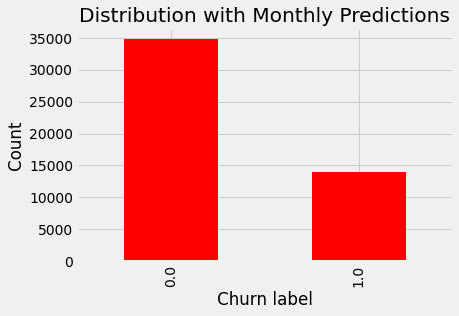

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

label_times['label'].value_counts().plot.bar(color = 'r');
plt.xlabel('Churn label'); plt.ylabel('Count'); plt.title('Distribution with Monthly Predictions');

In [0]:
import pickle

In [0]:
import pickle
pickle.dump(label_customer, open('/content/drive/My Drive/Colab Notebooks/Churn.pkl', "wb" ))

In [0]:
label_customer = pickle.load( open( '/content/drive/My Drive/Colab Notebooks/Churn.pkl', "rb" ) )

In [0]:
pickle.dump(make_label_times, open('/content/drive/My Drive/Colab Notebooks/Churnlabel.pkl', "wb" ))

In [0]:
make_label_times = pickle.load( open( '/content/drive/My Drive/Colab Notebooks/Churnlabel.pkl', "rb" ) )

In [0]:
pickle.dump(label_times, open('/content/drive/My Drive/Colab Notebooks/labeltimes.pkl', "wb" ))

In [0]:
label_times = pickle.load( open( '/content/drive/My Drive/Colab Notebooks/labeltimes.pkl', "rb" ) )

In [0]:
label_times.to_csv(r'/content/drive/My Drive/Colab Notebooks/laMon.csv', index = False)

In [67]:
label_times_14 = make_label_times(trans, prediction_date = 'SMS', churn_days = 14,
                               lead_time = 1, prediction_window = 1)
label_times_14.tail(10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


,user_id,cutoff_time,label,days_to_churn,churn_date
2,517615893,2018-11-01,NaN,NaN,NaT
0,517616055,2020-01-01,0.0,NaN,NaT
1,517616055,2020-01-15,NaN,NaN,NaT
2,517616055,2020-02-01,NaN,NaN,NaT
0,517617726,2019-07-01,0.0,NaN,NaT
1,517617726,2019-07-15,NaN,NaN,NaT
2,517617726,2019-08-01,NaN,NaN,NaT
0,517618138,2019-05-01,0.0,NaN,NaT
1,517618138,2019-05-15,NaN,NaN,NaT
2,517618138,2019-06-01,NaN,NaN,NaT


In [68]:
label_times_14.shape

(366219, 5)

In [70]:
label_times_14['label'].value_counts()

0.0    97197
1.0    15141
Name: label, dtype: int64

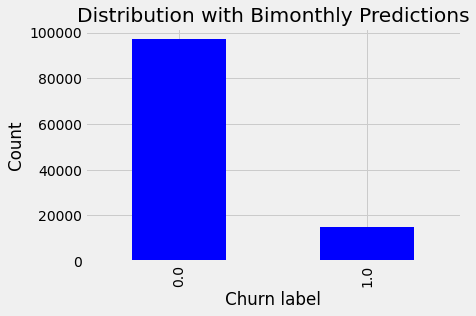

In [71]:
label_times_14['label'].value_counts().plot.bar(color = 'b');
plt.xlabel('Churn label'); plt.ylabel('Count'); plt.title('Distribution with Bimonthly Predictions');

In [72]:

label_times_14['label'].isnull().sum()

253881

In [0]:
label_times_14.to_csv(r'/content/drive/My Drive/Colab Notebooks/laBi.csv', index = False)

In [0]:
pickle.dump(label_times_14, open('/content/drive/My Drive/Colab Notebooks/labeltimes_14.pkl', "wb" ))

In [0]:
label_times_14 = pickle.load( open( '/content/drive/My Drive/Colab Notebooks/labeltimes_14.pkl', "rb" ) )